First figure of the manuscript, introductory. 
- examples of raw traces (both LFP and gamma) during wake and sleep.
- associated ACF and PSD during sleep stages
- accompanying fits on the functions.

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.io import loadmat
from scipy import signal
import pickle
from ast import literal_eval
import matplotlib.pyplot as plt
from nilearn import surface as nisurf
import plotly.graph_objects as go

import mni_utils as uti
from mni_plots import (
    _set_font_params,
    fsize,
    save_figure,
    _get_figsize_inches,
    _get_fontsize_ratio,
)

Set appropriate fonts for plotting:

In [3]:
_set_font_params()

Paths and names:

In [4]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
tau_path = data_path.joinpath("Results_acf_fit_exp")
exp_path = data_path.joinpath("Results_psd_exp")
gamma_path = data_path.joinpath("Results_gamma")
fig_path = data_path.joinpath("Figures")
surfaces_dir = Path("C:/Users/ricca/mne_data/MNE-sample-data/subjects/fsaverage/surf")

Get data and info:

In [5]:
data = loadmat(data_path.joinpath("MatlabFile.mat"))
data_W = data["Data_W"].T
data_N2 = data["Data_N2"].T
data_N3 = data["Data_N3"].T
data_R = data["Data_R"].T

# Export info as a dataframe
ch_names = data["ChannelName"].squeeze()
ch_types = data["ChannelType"].squeeze()
ch_regs = data["ChannelRegion"].squeeze()
pat_ids = data["Patient"].squeeze()
gender = data["Gender"].squeeze()
age = data["AgeAtTimeOfStudy"].squeeze()
ch_pos = data["ChannelPosition"].squeeze()
regions_map = {i + 1: r[0][0] for i, r in enumerate(data["RegionName"])}
sfreq = data["SamplingFrequency"][0][0]
df_info = pd.DataFrame(
    {
        "pat": pat_ids,
        "chan": [ch[0] for ch in ch_names],
        "type": [t[0] for t in ch_types],
        "region": ch_regs,
        "mni_x": ch_pos[:, 0],
        "mni_y": ch_pos[:, 1],
        "mni_z": ch_pos[:, 2],
    }
)

Selected patients and channels to plot:

In [6]:
# Patients and channels to use
pats = [34, 34]  # [41, 41] #[93, 93]  #[76, 76] # [78, 78]
chans = [
    "GD034Lr_3",
    "GD034Lu_2",
]  # ["GD041Lr_6",	"GD041Ls_6"]	 #["NG093RF143",	"NG093RF144"]	 # ["MM076LOF5",	"MM076LOF6"]
# [
#     "MM078LH8",
#     "MM078LOF3",
# ]  # ["NG103LG15", "NG103LT14"]
lobes = ["Frontal", "Temporal"]

# Times for traces plot
t_start = 2
t_end = t_start + 1

Define names and colors:

In [7]:
stages_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
color_stages = {"W": "red", "N3": "purple", "R": "green"}

### A) Plot overview of all channels in the dataset:

In [9]:
# Load surface
# surface = nisurf.load_surf_mesh(data_path.joinpath("surfaces", "cortex_20484.surf.gii"))
surface_left = nisurf.load_surf_mesh(surfaces_dir.joinpath("lh.pial"))
surface_rigth = nisurf.load_surf_mesh(surfaces_dir.joinpath("rh.pial"))

# First, create surface plot
surf_left = go.Mesh3d(
    x=surface_left.coordinates[:, 0],
    y=surface_left.coordinates[:, 1],
    z=surface_left.coordinates[:, 2],
    i=surface_left.faces[:, 0],
    j=surface_left.faces[:, 1],
    k=surface_left.faces[:, 2],
    color="gainsboro",
    opacity=0.2,
    hoverinfo="skip",
    showscale=False,
)
surf_right = go.Mesh3d(
    x=surface_rigth.coordinates[:, 0],
    y=surface_rigth.coordinates[:, 1],
    z=surface_rigth.coordinates[:, 2],
    i=surface_rigth.faces[:, 0],
    j=surface_rigth.faces[:, 1],
    k=surface_rigth.faces[:, 2],
    color="gainsboro",
    opacity=0.2,
    hoverinfo="skip",
    showscale=False,
)

# Then, the scatterplot
scatter_trace = go.Scatter3d(
    x=df_info["mni_x"],
    y=df_info["mni_y"],
    z=df_info["mni_z"],
    mode="markers",
    marker=dict(
        size=2,
        color="black",
        opacity=0.8,
    ),
    hoverinfo="skip",
)

#  Highlight selected channels
mni_coords = df_info.loc[
    df_info["chan"].isin(chans), ["mni_x", "mni_y", "mni_z"]
].to_numpy()
ch_traces = go.Scatter3d(
    x=mni_coords[:, 0],
    y=mni_coords[:, 1],
    z=mni_coords[:, 2],
    mode="markers",
    marker=dict(
        size=10,
        color="#e377c2",
        opacity=0.99,
    ),
    hoverinfo="skip",
)

# Put together the two plots
fig = go.Figure(
    data=[surf_left, surf_right, scatter_trace, ch_traces],
)

# Update the layout
fig.update_layout(
    {
        "paper_bgcolor": "rgba(0,0,0,0)",  # transparent, to make it dark set a=0.8
    },
    scene=dict(
        xaxis=dict(
            backgroundcolor="rgba(0,0,0,0)",
            gridcolor="rgba(0,0,0,0.0)",
            color="white",
            zeroline=False,
            showticklabels=False,
            title_text="",
        ),
        yaxis=dict(
            backgroundcolor="rgba(0,0,0,0)",
            gridcolor="rgba(0,0,0,0.0)",
            color="white",
            zeroline=False,
            showticklabels=False,
            title_text="",
        ),
        zaxis=dict(
            backgroundcolor="rgba(0,0,0,0)",
            gridcolor="rgba(0,0,0,0.0)",
            color="white",
            zeroline=False,
            showticklabels=False,
            title_text="",
        ),
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    scene_camera=dict(eye=dict(x=0, y=1.5, z=0)),
    showlegend=False,
)

# Frontal view
fig.write_image(fig_path.joinpath("Fig_0", f"Contacts_overview_front.svg"))

# Top view
fig.update_layout(
    scene_camera=dict(eye=dict(x=0, y=0, z=1.5)),
)
fig.write_image(fig_path.joinpath("Fig_0", f"Contacts_overview_top.svg"))

# Lateral view
fig.update_layout(
    scene_camera=dict(eye=dict(x=-1.5, y=0, z=0)),
)
fig.write_image(fig_path.joinpath("Fig_0", f"Contacts_overview_lat.svg"))

(Optional) Prepare data for CORTEO plotting:

In [10]:
df_plot_corteo = pd.DataFrame(
    columns=[
        "type",
        "model",
        "electrode",
        "name",
        "n",
        "color",
        "natus",
        "sm",
        "isOut",
        "isWM",
        "native_x",
        "native_y",
        "native_z",
        "mni_x",
        "mni_y",
        "mni_z",
    ]
)

df_plot_corteo["mni_x"] = df_info["mni_x"].to_numpy()
df_plot_corteo["mni_y"] = df_info["mni_y"].to_numpy()
df_plot_corteo["mni_z"] = df_info["mni_z"].to_numpy()
df_plot_corteo["type"] = "lead"
df_plot_corteo["model"] = df_info["type"].to_numpy()
df_plot_corteo["electrode"] = "ele"
df_plot_corteo["name"] = df_info["chan"].to_numpy()
df_plot_corteo["n"] = np.arange(1, df_info.shape[0] + 1)
df_plot_corteo["color"] = "#000"
df_plot_corteo["natus"] = df_info["chan"].to_numpy()
df_plot_corteo["sm"] = -1
df_plot_corteo["isOut"] = False
df_plot_corteo["isWM"] = False
df_plot_corteo["native_x"] = 0
df_plot_corteo["native_y"] = 0
df_plot_corteo["native_z"] = 0

# Color the electrodes of interest in pink
df_plot_corteo.loc[df_plot_corteo["name"].isin(chans), "color"] = "#e377c2"

df_plot_corteo.to_excel(
    data_path.joinpath("Cohort", "Electrodes", "Lookup.xlsx"), sheet_name="channels"
)

### B) Plot examples of traces:

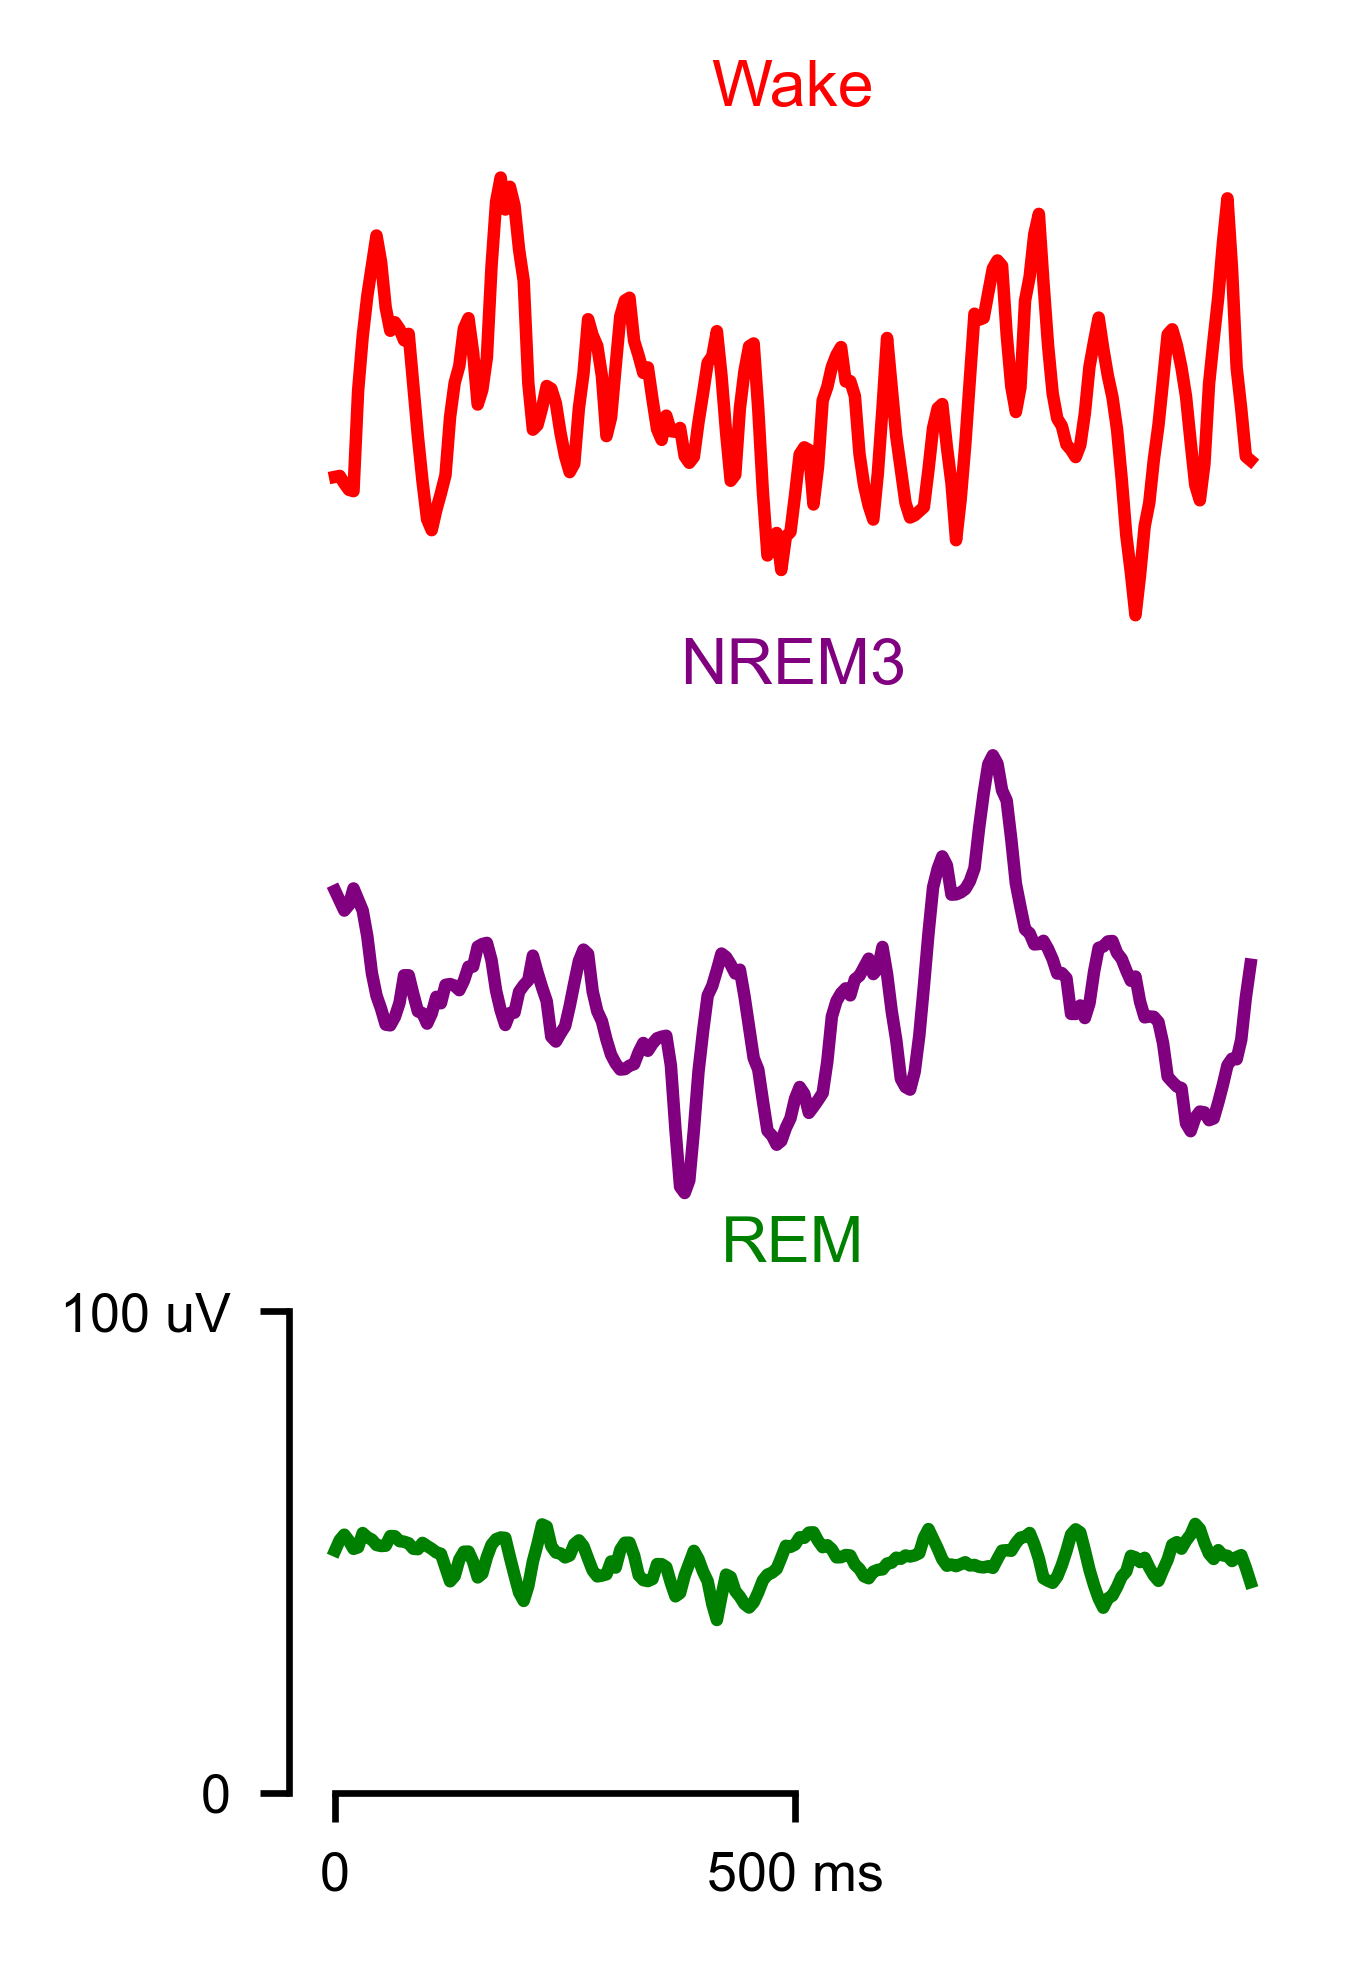

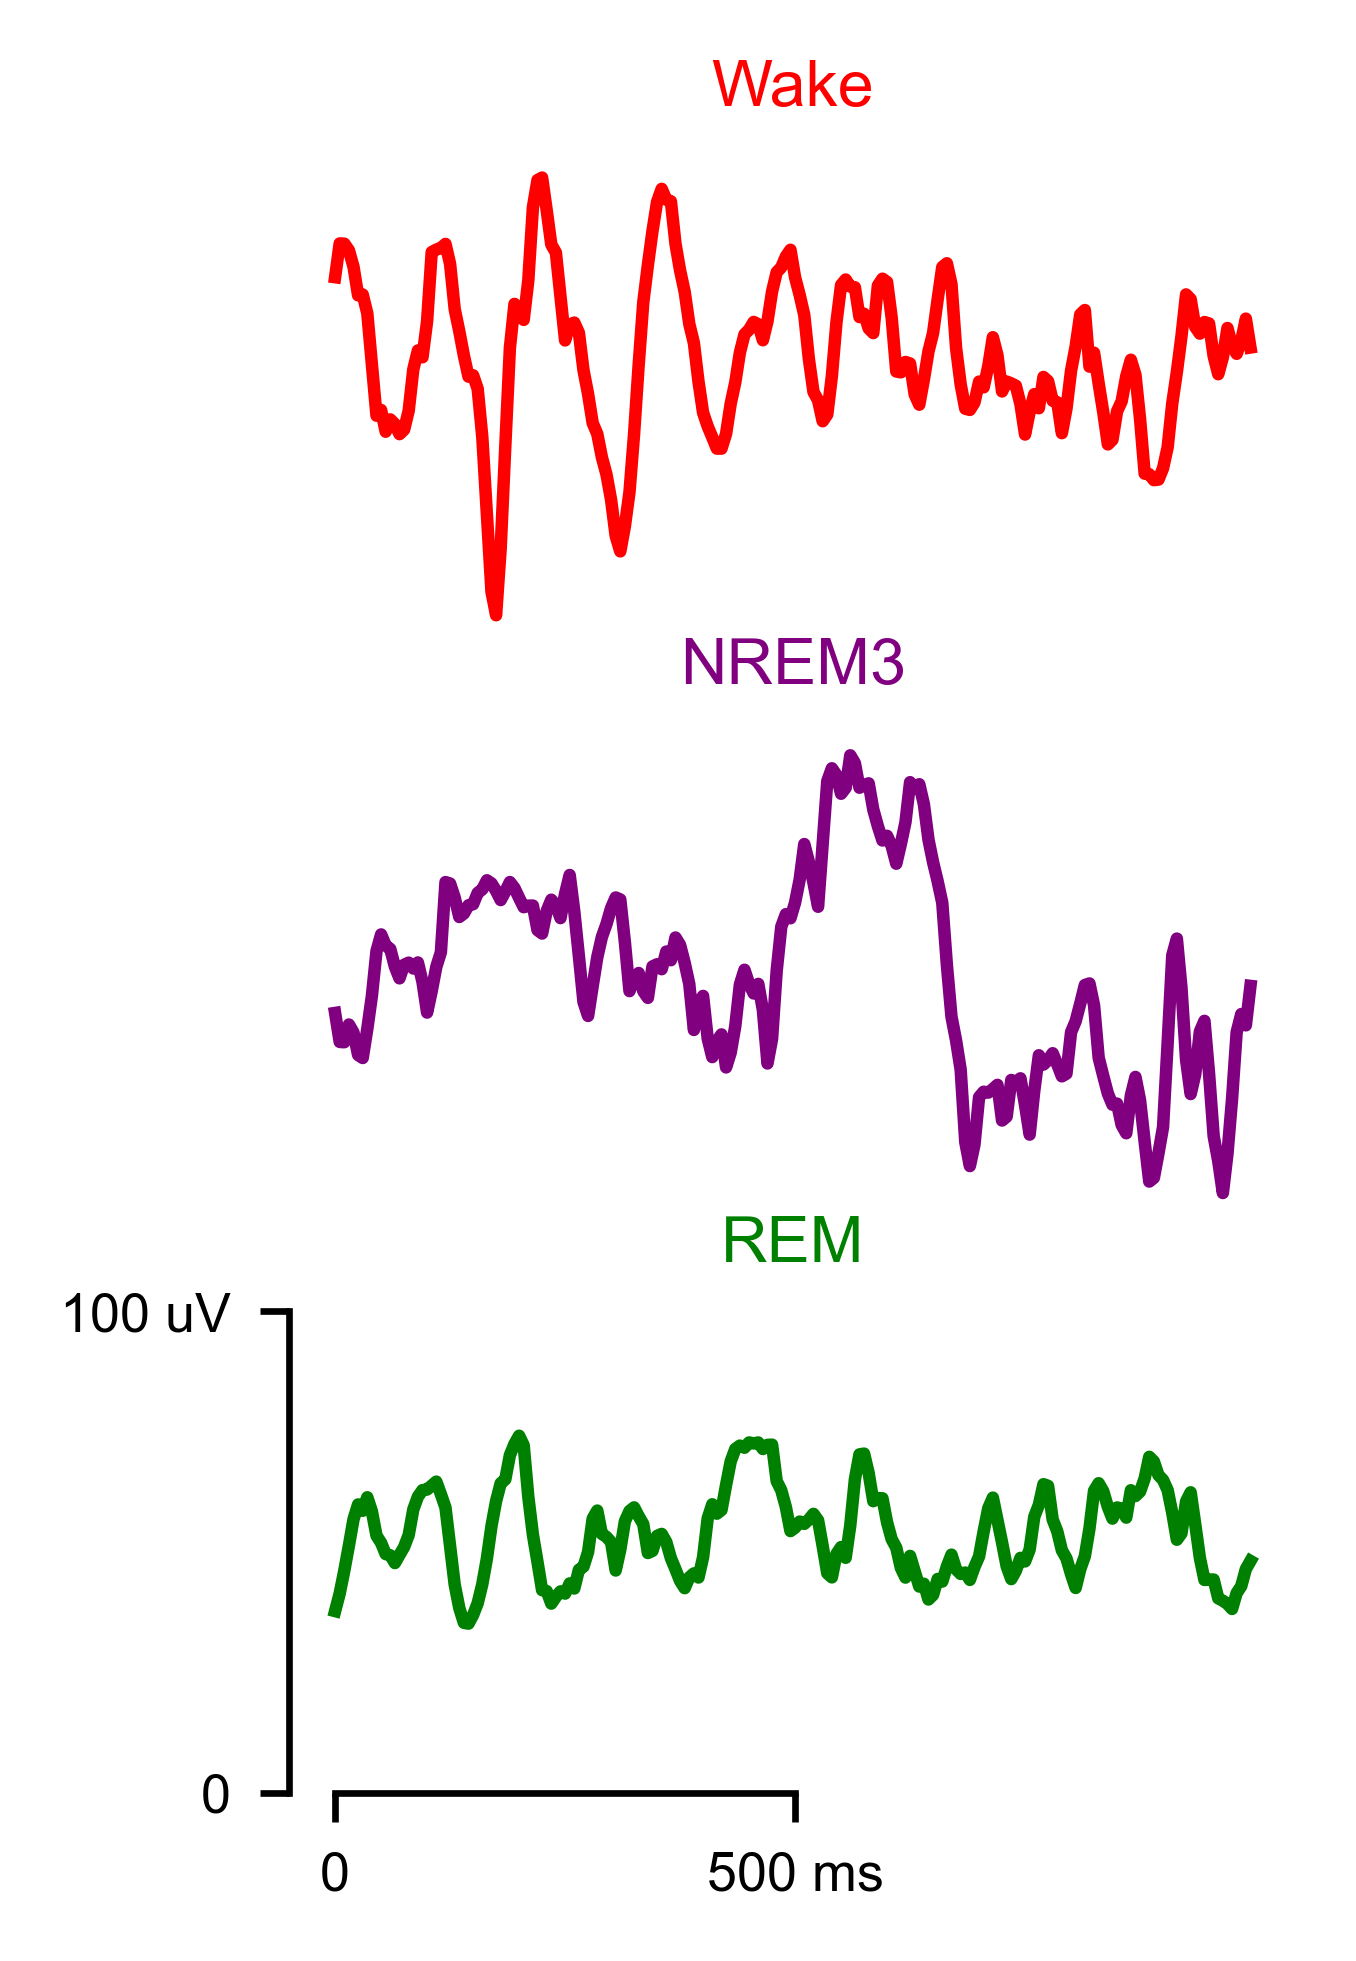

In [57]:
# Plot traces
idx_start = int(t_start * sfreq)
idx_end = int(t_end * sfreq)
# Figsize in cm
figsize = (5.5, 5.5)
for ch in chans:
    fig, axs = plt.subplots(
        3,
        1,
        figsize=_get_figsize_inches((5.5, 9)),
        # sharex=True,
        # sharey=True,
        dpi=600,
    )
    idx = df_info.loc[df_info["chan"] == ch].index[0]
    axs[0].plot(data_W[idx, idx_start:idx_end], c=color_stages["W"], label="Wake")
    axs[0].set_title("Wake", fontsize=fsize.TITLE_SIZE * _get_fontsize_ratio(figsize))
    axs[0].title.set_color(color_stages["W"])
    axs[1].plot(data_N3[idx, idx_start:idx_end], c=color_stages["N3"], label="NREM3")
    axs[1].set_title("NREM3", fontsize=fsize.TITLE_SIZE * _get_fontsize_ratio(figsize))
    axs[1].title.set_color(color_stages["N3"])
    axs[2].plot(data_R[idx, idx_start:idx_end], c=color_stages["R"], label="REM")
    axs[2].set_title("REM", fontsize=fsize.TITLE_SIZE * _get_fontsize_ratio(figsize))
    axs[2].title.set_color(color_stages["R"])
    for i in range(3):
        axs[i].spines[["top", "right"]].set_visible(False)
        if i == 2:
            axs[i].set_xticks(
                [0, int(sfreq / 2)],
                labels=["0", "500 ms"],
                fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
            )
            axs[i].spines["bottom"].set_bounds(0, int(sfreq / 2))
            axs[i].set_yticks(
                [-50, 50],
                labels=["0", "100 uV"],
                fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
            )
            axs[i].spines["left"].set_bounds(-50, 50)
        else:
            axs[i].spines[["bottom", "left"]].set_visible(False)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
    fig.savefig(fig_path.joinpath("Fig_0", f"Fig0_traces_{ch}.svg"), format="svg")
    plt.show()

#### Plot same examples, but filtered in the gamma band (do not use):

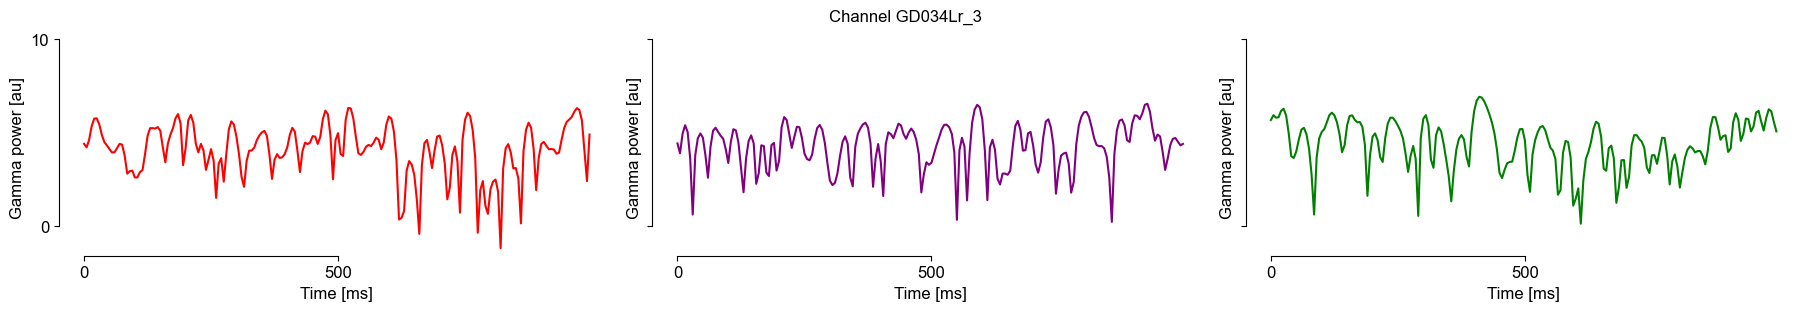

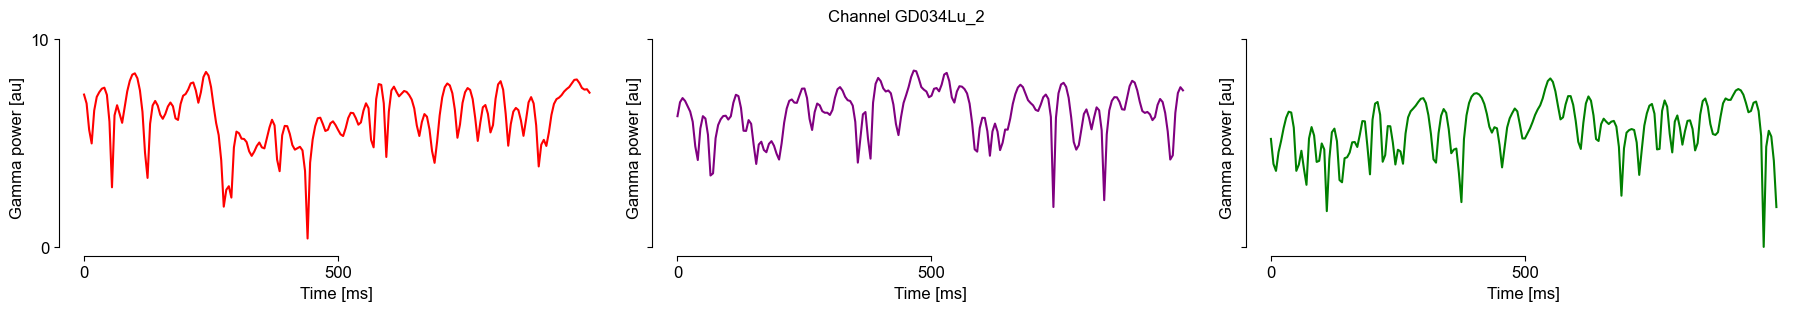

In [21]:
# Plot traces
idx_start = int(t_start * sfreq)
idx_end = int(t_end * sfreq)
for pat, ch in zip(pats, chans):
    fig, axs = plt.subplots(
        1, 3, figsize=(18, 3), sharex=True, sharey=True, layout="constrained"
    )
    # Create raw data
    for i, (stage, dat_stage) in enumerate(
        zip(["W", "N3", "R"], [data_W, data_N3, data_R])
    ):
        # Select data for patient and stage
        idx_pat = df_info.loc[df_info["pat"] == pat].index
        data_stage_pat = dat_stage[idx_pat]
        chans_stage_pat = df_info.loc[idx_pat, "chan"].to_list()
        # Create raw
        raw_stage_pat = uti.create_RawMNE(data_stage_pat, chans_stage_pat, sfreq)
        # Filter and get gamma
        raw_stage_pat.filter(40, 80, verbose=False)
        raw_stage_pat.apply_hilbert(envelope=True)
        # Apply log-transformation to make data more "normal"
        raw_stage_pat._data = np.log(raw_stage_pat._data**2)
        # Pick channel and time
        data_chan = raw_stage_pat.get_data(picks=ch, tmin=t_start, tmax=t_end)

        # Plot
        axs[i].plot(data_chan[0], c=color_stages[stage], label=stages_dict[stage])
        axs[i].spines[["top", "right"]].set_visible(False)
        axs[i].set_xticks([0, int(sfreq / 2)], labels=[0, 500], fontsize=12)
        axs[i].spines["bottom"].set_bounds(0, int(sfreq / 2))
        axs[i].set_xlabel("Time [ms]", fontsize=12)
        axs[i].set_yticks([-5, 5], labels=[0, 10], fontsize=12)
        axs[i].spines["left"].set_bounds(-5, 5)
        axs[i].set_ylabel("Gamma power [au]", fontsize=12)
    fig.suptitle(f"Channel {ch}")
    fig.savefig(fig_path.joinpath("Fig_0", f"traces_{ch}_gamma.svg"), format="svg")
    plt.show()

### C) Plot ACFs from the channels:

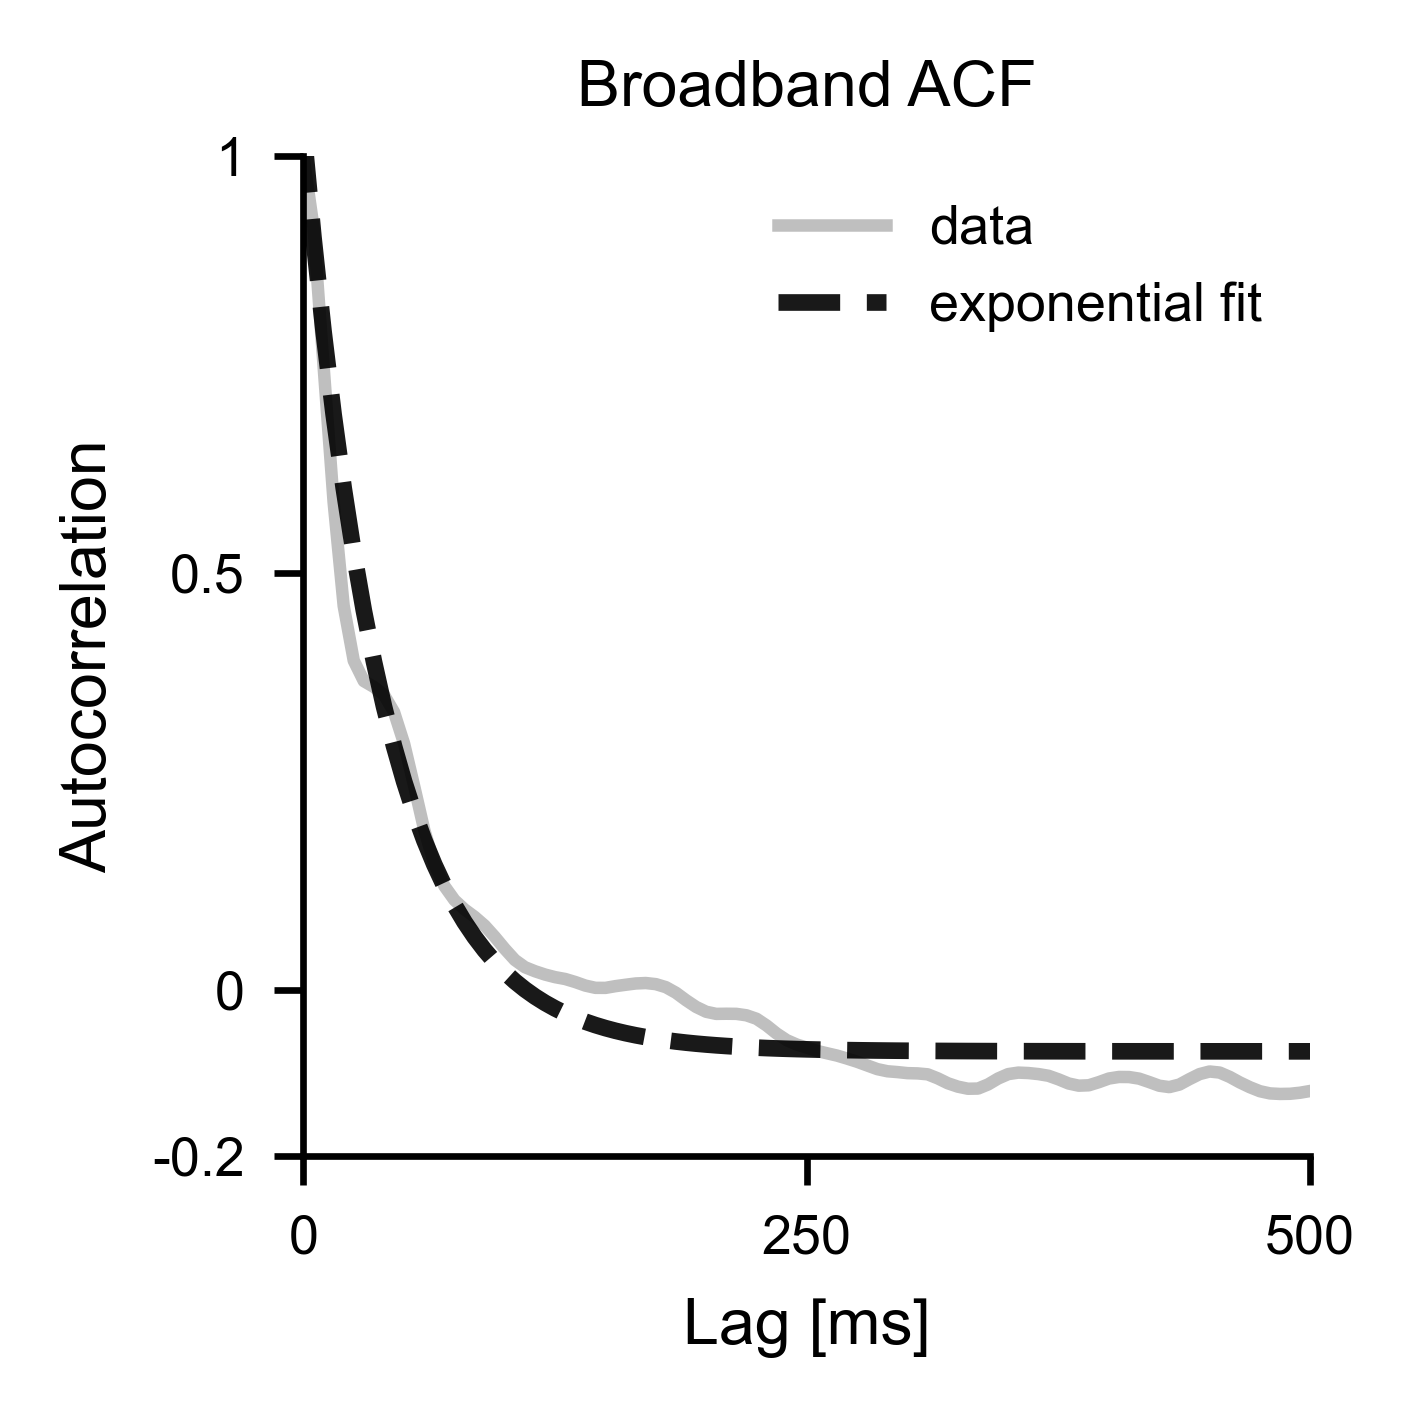

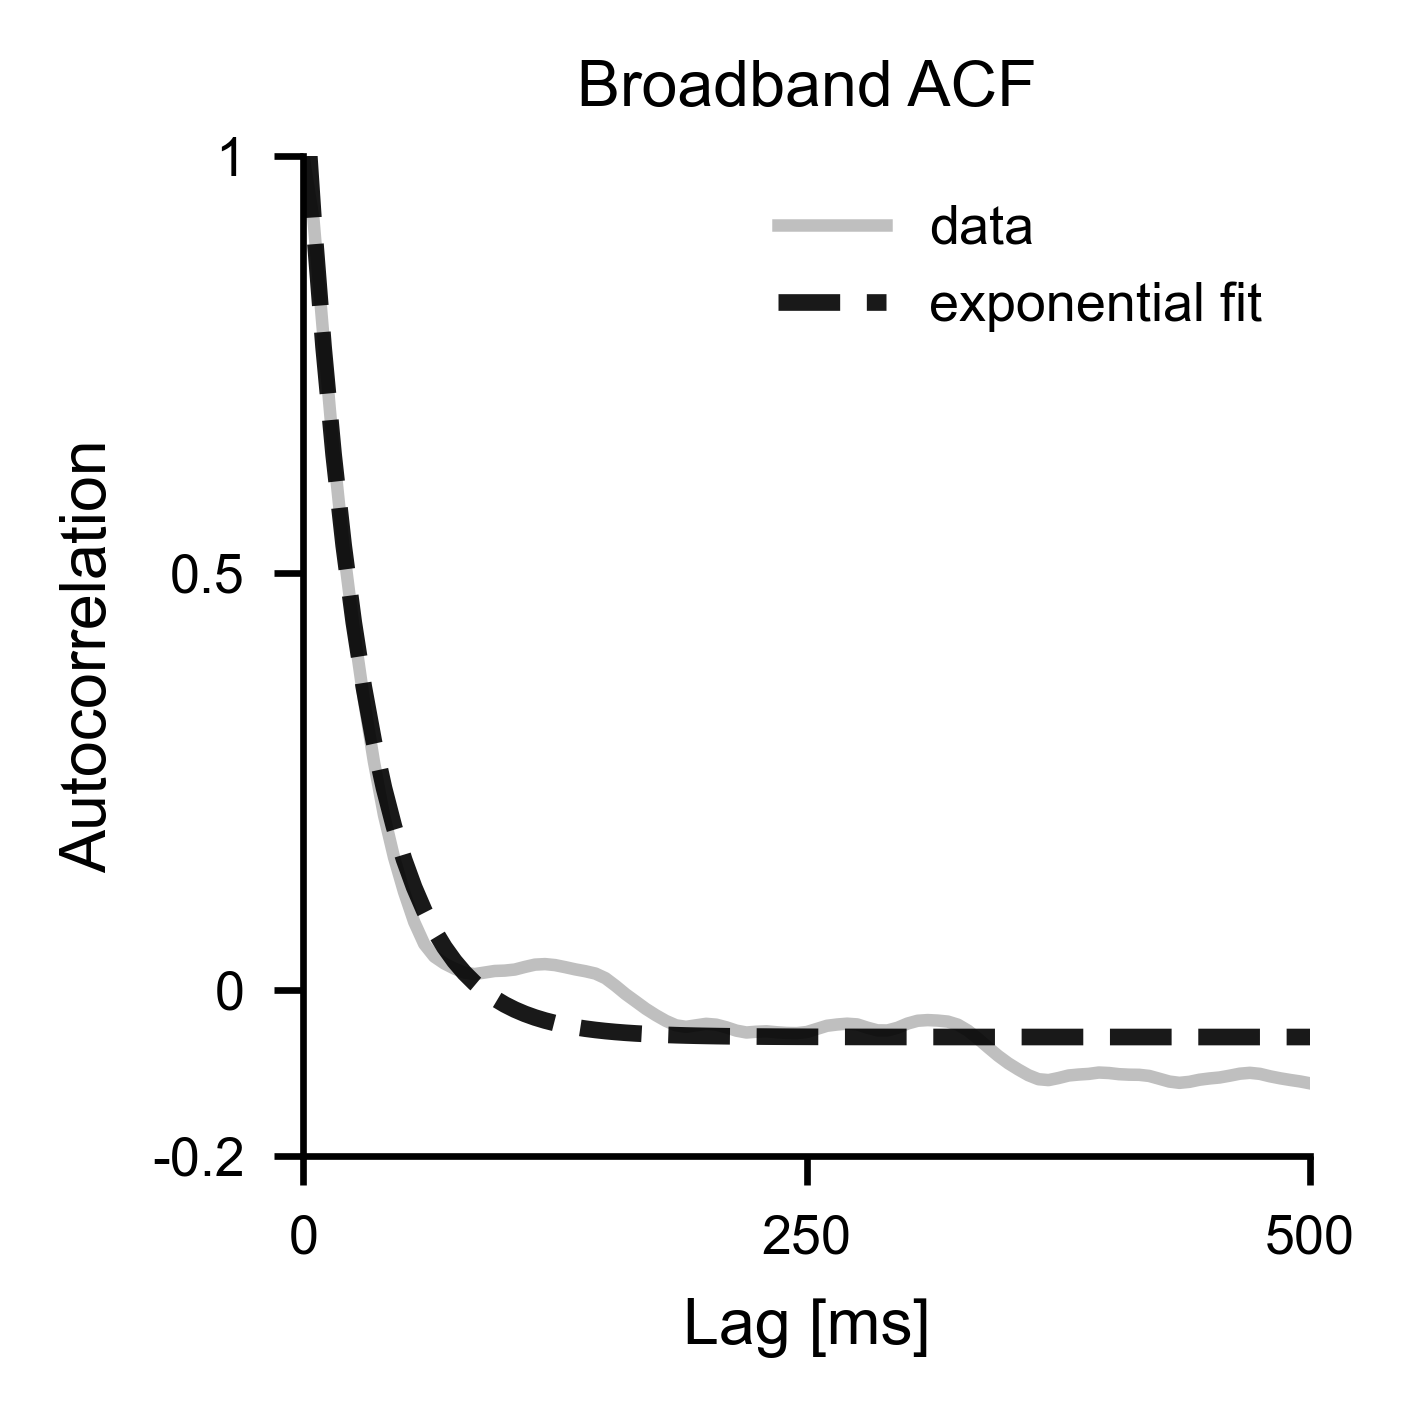

In [56]:
# Figsize in cm
figsize = (5.5, 5.5)

for pat, chan, lobe in zip(pats, chans, lobes):
    pat_dir = tau_path.joinpath(str(pat).zfill(3))
    fig, ax = plt.subplots(figsize=_get_figsize_inches(figsize), dpi=600)

    for stage in ["R"]:  # ["W", "N3", "R"]:
        # Load ACF
        with open(
            pat_dir.joinpath("ACF/" + str(pat).zfill(3) + "_" + stage.lower() + ".pkl"),
            "rb",
        ) as f:
            acf_pat_stage = pickle.load(f)
        idx_chan = acf_pat_stage["chans"].index(chan)

        # Load fit
        df_fit = pd.read_csv(
            pat_dir.joinpath("ACF/" + str(pat).zfill(3) + "_" + stage + "_tau.csv"),
            index_col=0,
        )
        params = literal_eval(
            df_fit.loc[chan, "params"]
            .replace("  ", " ")
            .replace("  ", " ")
            .replace("[ ", "[")
            .replace(" ", ",")
        )

        # Figure ACF
        ax.plot(
            acf_pat_stage["lags"] * 1000,
            acf_pat_stage["acf"][:, idx_chan].mean(axis=0),
            c="grey",
            label="data",
            lw=1.5,
            alpha=0.5,
        )
        ax.plot(
            acf_pat_stage["lags"] * 1000,
            params[1] * (np.exp(-acf_pat_stage["lags"] / params[0]) + params[2]),
            c="k",
            ls="--",
            lw=2,
            alpha=0.9,
            label="exponential fit",
        )
        # title = " - ".join([str(pat), chan, lobe])
        ax.set_title(
            "Broadband ACF", fontsize=fsize.TITLE_SIZE * _get_fontsize_ratio(figsize)
        )
        ax.set_xlim(0, 500)
        ax.set_xticks(
            [0, 250, 500],
            labels=[0, 250, 500],
            fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
        )
        ax.set_xlabel(
            "Lag [ms]", fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio(figsize)
        )
        ax.set_ylim(-0.2, 1)
        ax.set_yticks(
            [-0.2, 0, 0.5, 1],
            labels=[-0.2, 0, 0.5, 1],
            fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
        )
        ax.set_ylabel(
            "Autocorrelation", fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio(figsize)
        )
        ax.spines[["top", "right"]].set_visible(False)
    ax.legend(frameon=False, fontsize=fsize.TEXT_SIZE * _get_fontsize_ratio(figsize))
    fig.savefig(fig_path.joinpath("Fig_0", f"Fig0_ACF_{pat}_{chan}.svg"), format="svg")

    plt.show()

ACF of gamma activity

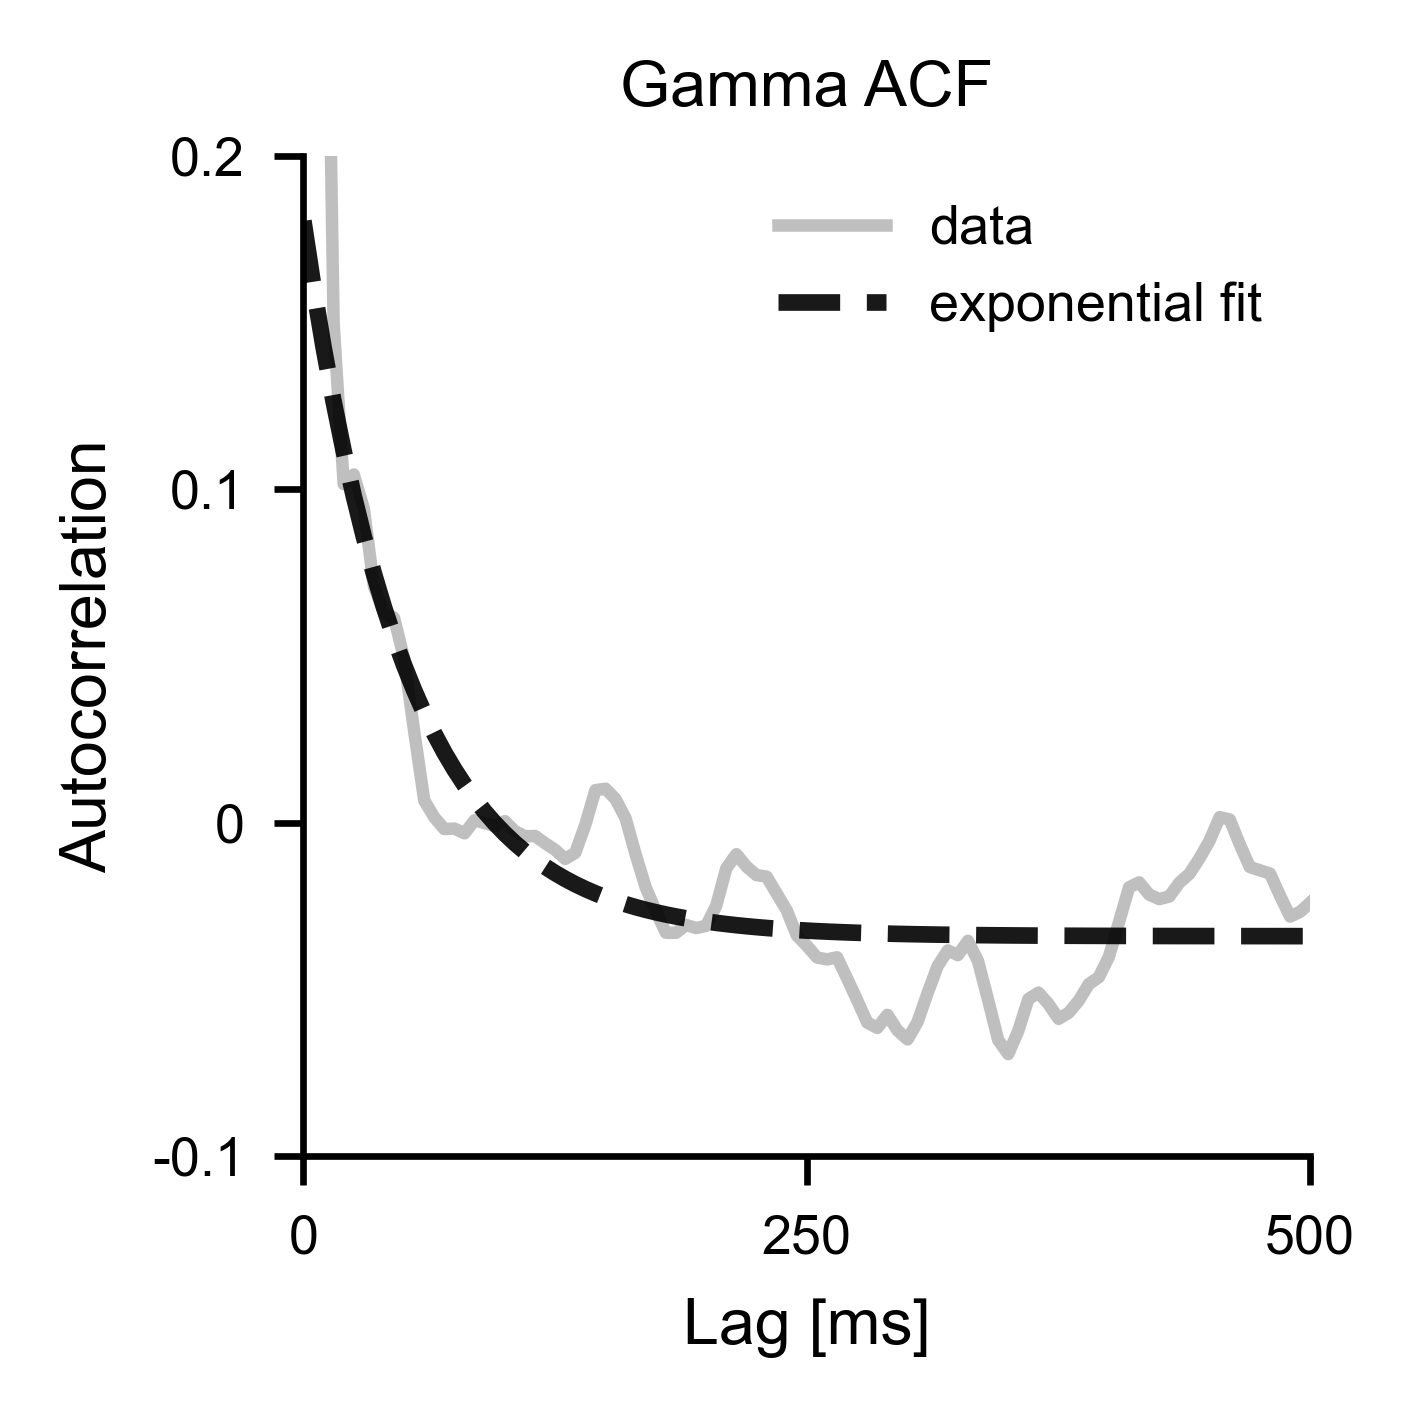

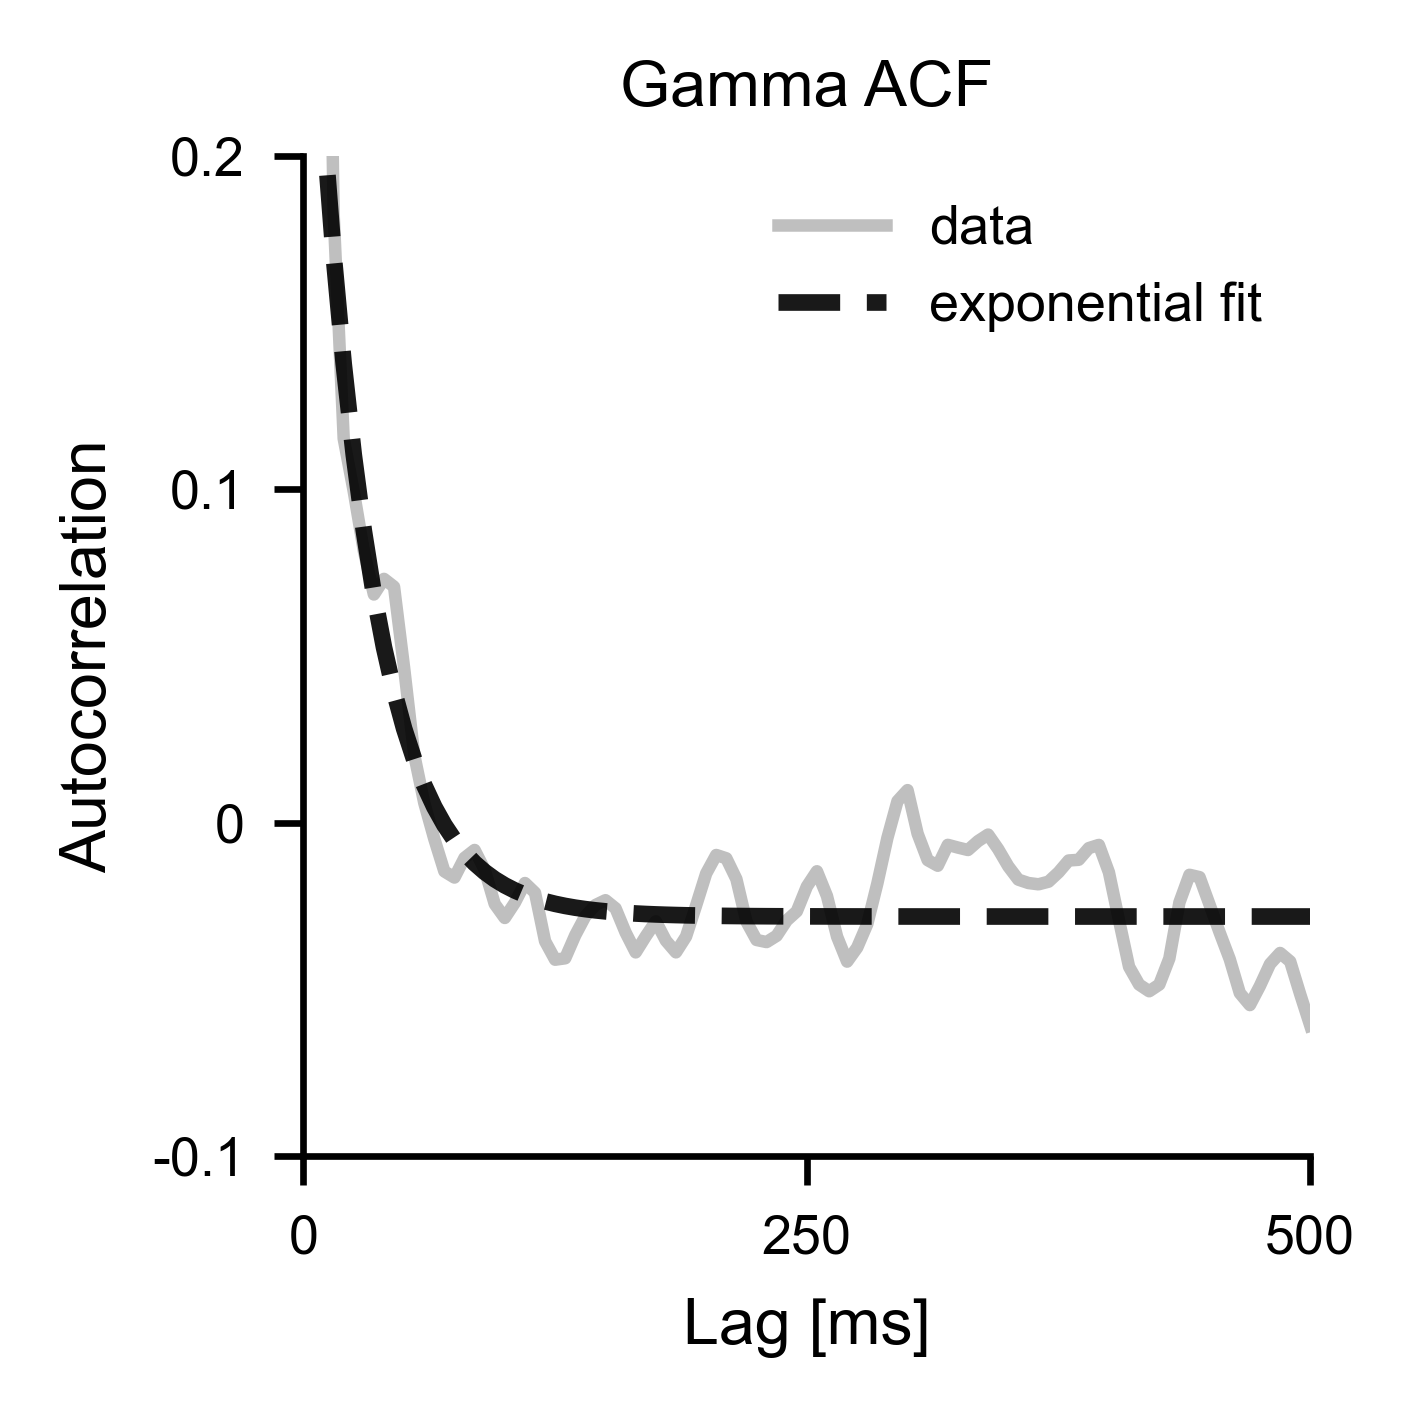

In [55]:
# Figsize in cm
figsize = (5.5, 5.5)

for pat, chan, lobe in zip(pats, chans, lobes):
    pat_dir = gamma_path.joinpath(str(pat).zfill(3))
    fig, ax = plt.subplots(figsize=_get_figsize_inches(figsize), dpi=600)

    for stage in ["W"]:  # , "N3", "R"]:
        # Load ACF
        with open(
            pat_dir.joinpath("ACF/" + str(pat).zfill(3) + "_" + stage.lower() + ".pkl"),
            "rb",
        ) as f:
            acf_pat_stage = pickle.load(f)
        idx_chan = acf_pat_stage["chans"].index(chan)

        # Load fit
        df_fit = pd.read_csv(
            pat_dir.joinpath("ACF/" + str(pat).zfill(3) + "_" + stage + "_tau.csv"),
            index_col=0,
        )
        params = literal_eval(
            df_fit.loc[chan, "params"]
            .replace("  ", " ")
            .replace("  ", " ")
            .replace("[ ", "[")
            .replace(" ", ",")
        )

        # Figure ACF
        ax.plot(
            acf_pat_stage["lags"] * 1000,
            acf_pat_stage["acf"][:, idx_chan].mean(axis=0),
            c="grey",
            label="data",
            lw=1.5,
            alpha=0.5,
        )
        ax.plot(
            acf_pat_stage["lags"] * 1000,
            params[1] * (np.exp(-acf_pat_stage["lags"] / params[0]) + params[2]),
            c="k",
            ls="--",
            lw=2,
            alpha=0.9,
            label="exponential fit",
        )
        # title = " - ".join([str(pat), chan, lobe])
        ax.set_title(
            "Gamma ACF", fontsize=fsize.TITLE_SIZE * _get_fontsize_ratio(figsize)
        )
        ax.set_xlim(0, 500)
        ax.set_xticks(
            [0, 250, 500],
            labels=[0, 250, 500],
            fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
        )
        ax.set_xlabel(
            "Lag [ms]", fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio(figsize)
        )
        ax.set_ylim(-0.1, 0.2)
        ax.set_yticks(
            [-0.1, 0, 0.1, 0.2],
            labels=[-0.1, 0, 0.1, 0.2],
            fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
        )
        ax.set_ylabel(
            "Autocorrelation", fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio(figsize)
        )
        ax.spines[["top", "right"]].set_visible(False)
    ax.legend(frameon=False, fontsize=fsize.TEXT_SIZE * _get_fontsize_ratio(figsize))
    fig.savefig(
        fig_path.joinpath("Fig_0", f"Fig0_ACF_{pat}_{chan}_gamma.svg"), format="svg"
    )

    plt.show()

Plot PSDs from the channels:

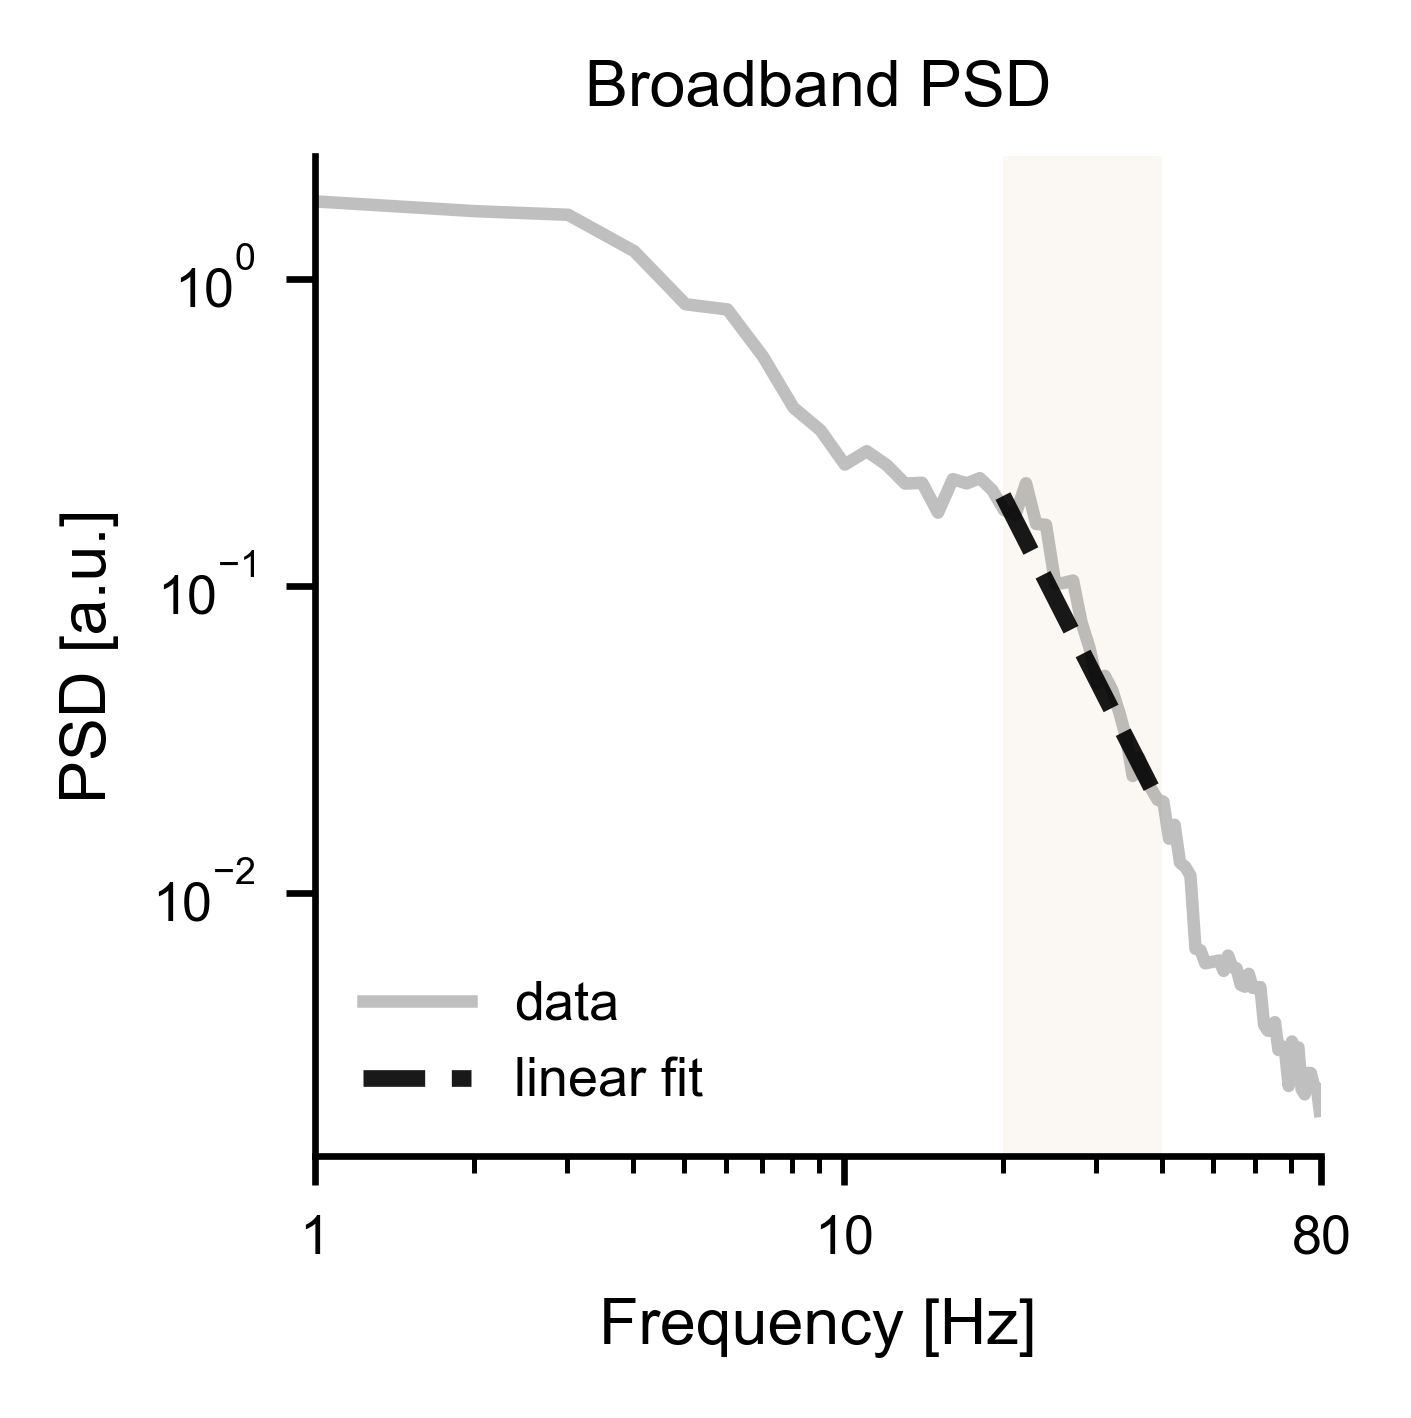

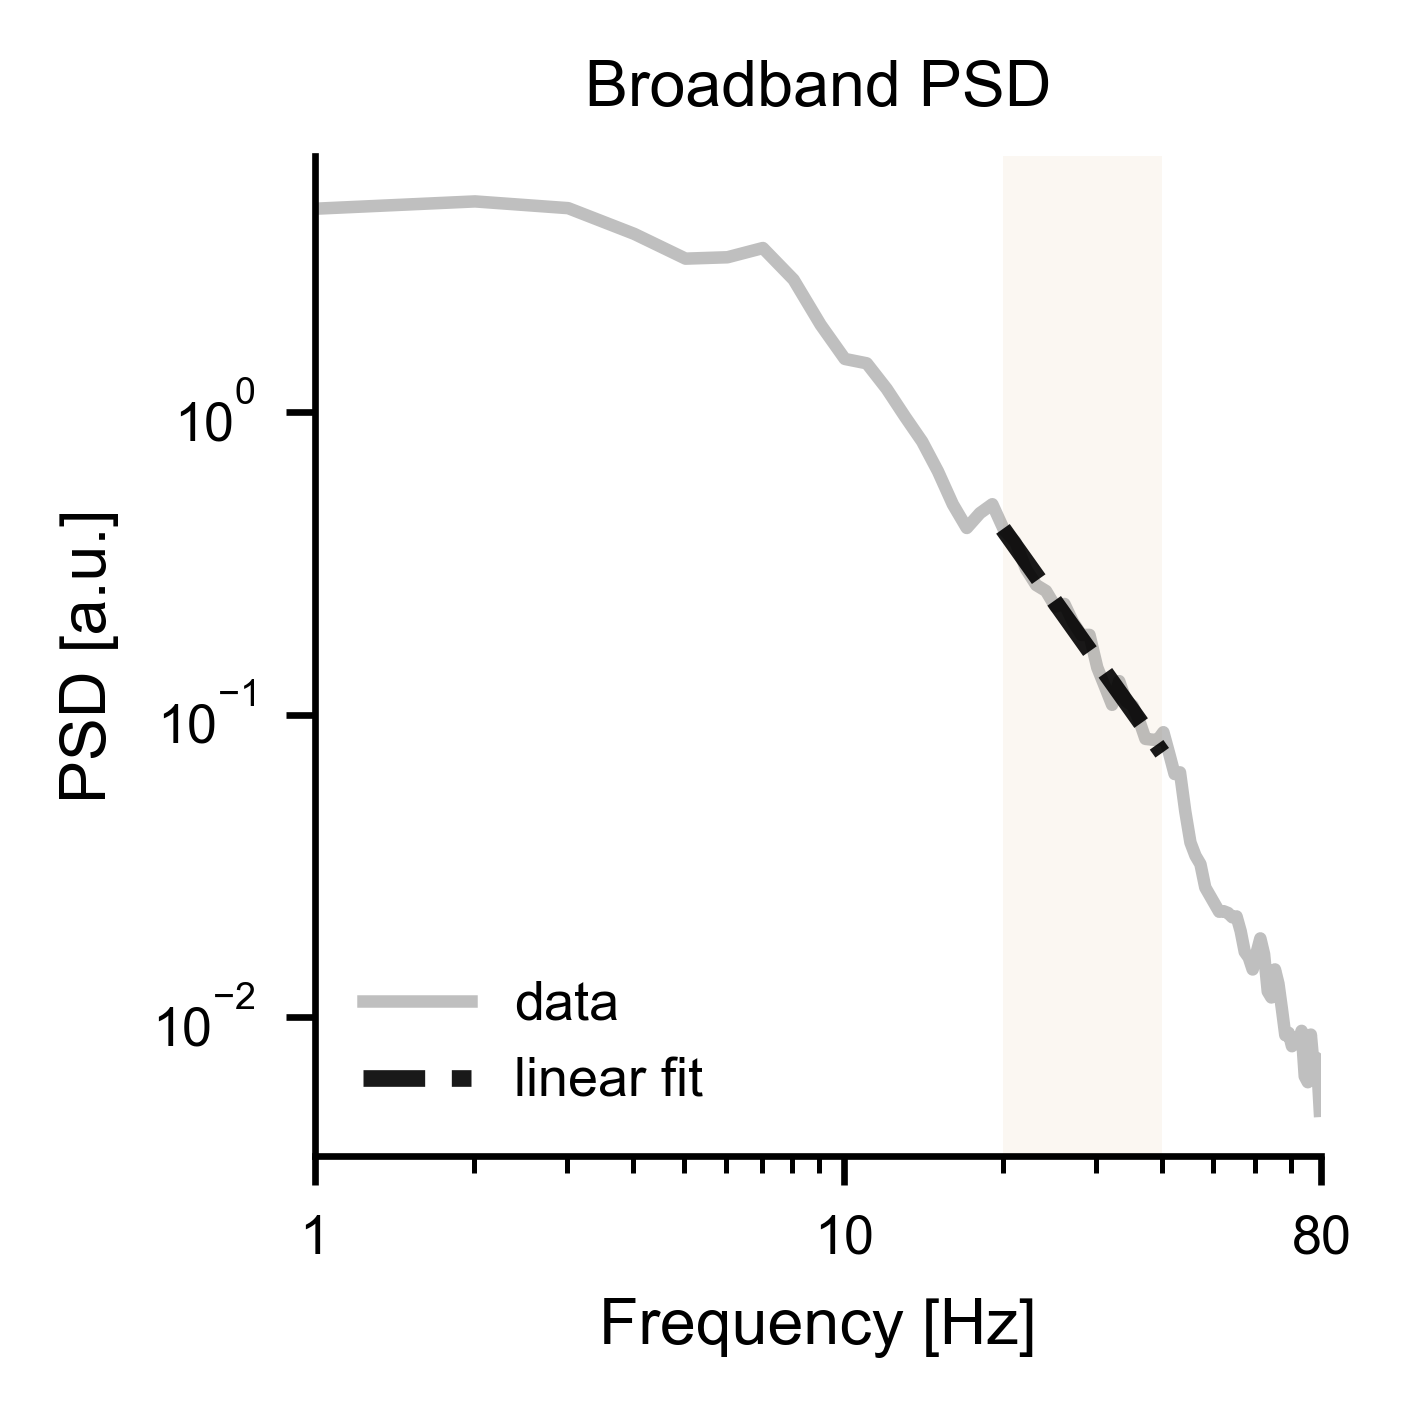

In [58]:
# Figsize in cm
figsize = (5.5, 5.5)

for pat, chan, lobe in zip(pats, chans, lobes):
    pat_dir = exp_path.joinpath(str(pat).zfill(3))
    fig, ax = plt.subplots(figsize=_get_figsize_inches(figsize), dpi=600)

    for stage in ["R"]:  # , "N3", "R"]:
        # Load PSD
        with open(
            pat_dir.joinpath("PSD/" + str(pat).zfill(3) + "_" + stage.lower() + ".pkl"),
            "rb",
        ) as f:
            psd_pat_stage = pickle.load(f)
        idx_chan = psd_pat_stage["chans"].index(chan)

        # Load spectral fit
        df_fit = pd.read_csv(
            pat_dir.joinpath("PSD/" + str(pat).zfill(3) + "_" + stage + "_aper.csv"),
            index_col=0,
        )
        off, exp = df_fit.loc[chan, ["off", "exp"]]

        # Figure ACF
        ax.plot(
            psd_pat_stage["freqs"],
            10 ** np.mean(np.log10(psd_pat_stage["psd"][:, idx_chan]), axis=0),
            c="grey",
            label="data",
            lw=1.5,
            alpha=0.5,
        )
        freqs_plot = np.linspace(20, 40, 100)
        ax.plot(
            freqs_plot,
            10 ** (off - 12) / (freqs_plot**exp),
            c="k",
            ls="--",
            lw=2,
            alpha=0.9,
            label="linear fit",
        )
        ax.axvspan(20, 40, facecolor="burlywood", alpha=0.1, edgecolor="none")
        ax.set_title("Broadband PSD", fontsize=fsize.TITLE_SIZE * _get_fontsize_ratio(figsize))
        ax.set_xscale("log")
        ax.set_xlim(1, 80)
        ax.set_xticks(
            [1, 10, 80],
            labels=[1, 10, 80],
            fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
        )
        ax.set_xlabel(
            "Frequency [Hz]", fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio(figsize)
        )
        ax.set_yscale("log")
        ax.tick_params(axis="y", which="minor", left=False)
        ax.tick_params(
            axis="y",
            which="major",
            labelsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
        )
        ax.set_ylabel(
            "PSD [a.u.]", fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio(figsize)
        )
        ax.spines[["top", "right"]].set_visible(False)

    ax.legend(frameon=False, fontsize=fsize.TEXT_SIZE * _get_fontsize_ratio(figsize))
    fig.savefig(fig_path.joinpath("Fig_0", f"Fig0_PSD_{pat}_{chan}.svg"), format="svg")

    plt.show()

Compute cross-correlation between channels:

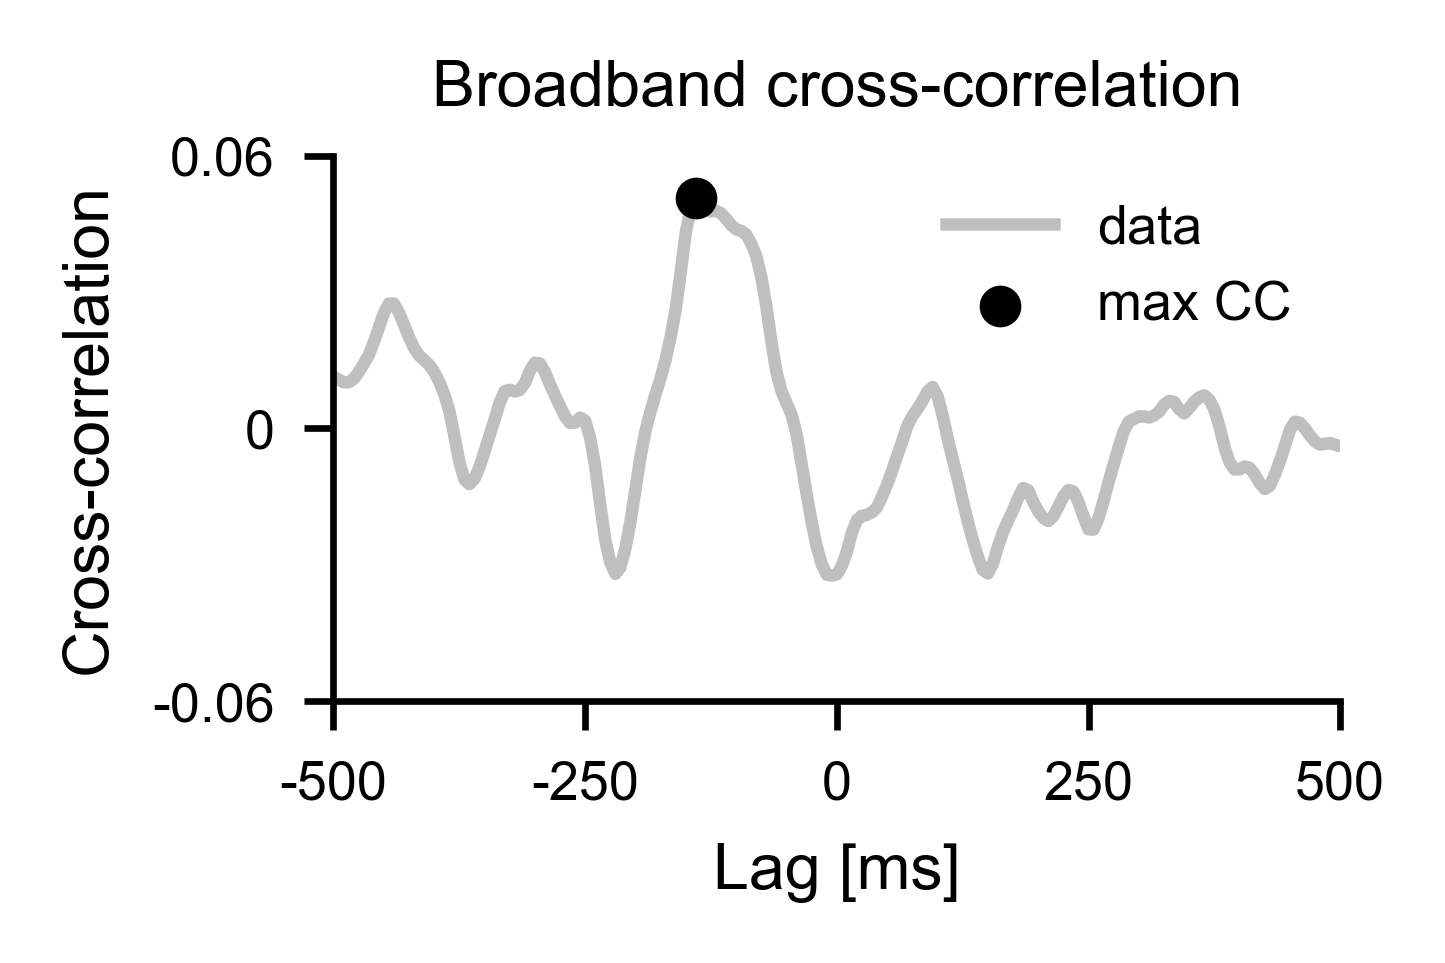

In [53]:
# Figsize in cm
figsize = (5.5, 5.5)

fig, ax = plt.subplots(figsize=_get_figsize_inches((5.5, 3)), dpi=600)

for stage, data_stage in zip(
    ["R"], [data_R]
):  # ["W", "N3", "R"], [data_W, data_N3, data_R]):

    # Data for 2 channels
    data_ch1 = data_stage[df_info.index[df_info["chan"] == chans[0]]]
    data_ch2 = data_stage[df_info.index[df_info["chan"] == chans[1]]]

    raw = uti.create_RawMNE(np.concatenate([data_ch1, data_ch2], axis=0), chans, sfreq)
    epo = uti.create_epo(raw)

    # Get epoched data
    data_ch1 = epo.get_data(picks=chans[0]).squeeze()
    data_ch2 = epo.get_data(picks=chans[1]).squeeze()

    # Compute cross-correlation
    corr_avg = []
    for k in range(len(data_ch1)):
        ch1_norm = (data_ch1[k] - data_ch1[k].mean()) / np.linalg.norm(data_ch1[k])
        ch2_norm = (data_ch2[k] - data_ch2[k].mean()) / np.linalg.norm(data_ch2[k])
        corr = signal.correlate(ch1_norm, ch2_norm, mode="same")
        lags = signal.correlation_lags(len(ch1_norm), len(ch2_norm), mode="same")
        corr_avg.append(corr)
    corr_avg = np.array(corr_avg).mean(axis=0)
    corr_max = np.max(np.abs(corr_avg))

    # Plot
    ax.plot(
        lags * 1000 / sfreq,
        corr_avg,
        c="grey",
        label="data",
        lw=1.5,
        alpha=0.5,
    )
    # Max
    ax.scatter(
        lags[np.argmax(np.abs(corr_avg))] * 1000 / sfreq,
        corr_max,
        c="k",
        s=16,
        label="max CC",
        zorder=4,
    )
    # Plot parameters
    ax.set_title(
        "Broadband cross-correlation",
        fontsize=fsize.TITLE_SIZE * _get_fontsize_ratio(figsize),
    )
    ax.set_xlim(-500, 500)
    ax.set_xticks(
        [-500, -250, 0, 250, 500],
        labels=[-500, -250, 0, 250, 500],
        fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
    )
    ax.set_xlabel("Lag [ms]", fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio(figsize))
    ax.set_ylim(-0.06, 0.06)
    ax.set_yticks(
        [-0.06, 0, 0.06],
        labels=[-0.06, 0, 0.06],
        fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
    )
    ax.set_ylabel(
        "Cross-correlation", fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio(figsize)
    )
    ax.spines[["top", "right"]].set_visible(False)

ax.legend(frameon=False, fontsize=fsize.TEXT_SIZE * _get_fontsize_ratio(figsize))
fig.savefig(fig_path.joinpath("Fig_0", f"Fig0_CC_{pats[0]}.svg"), format="svg")
plt.show()

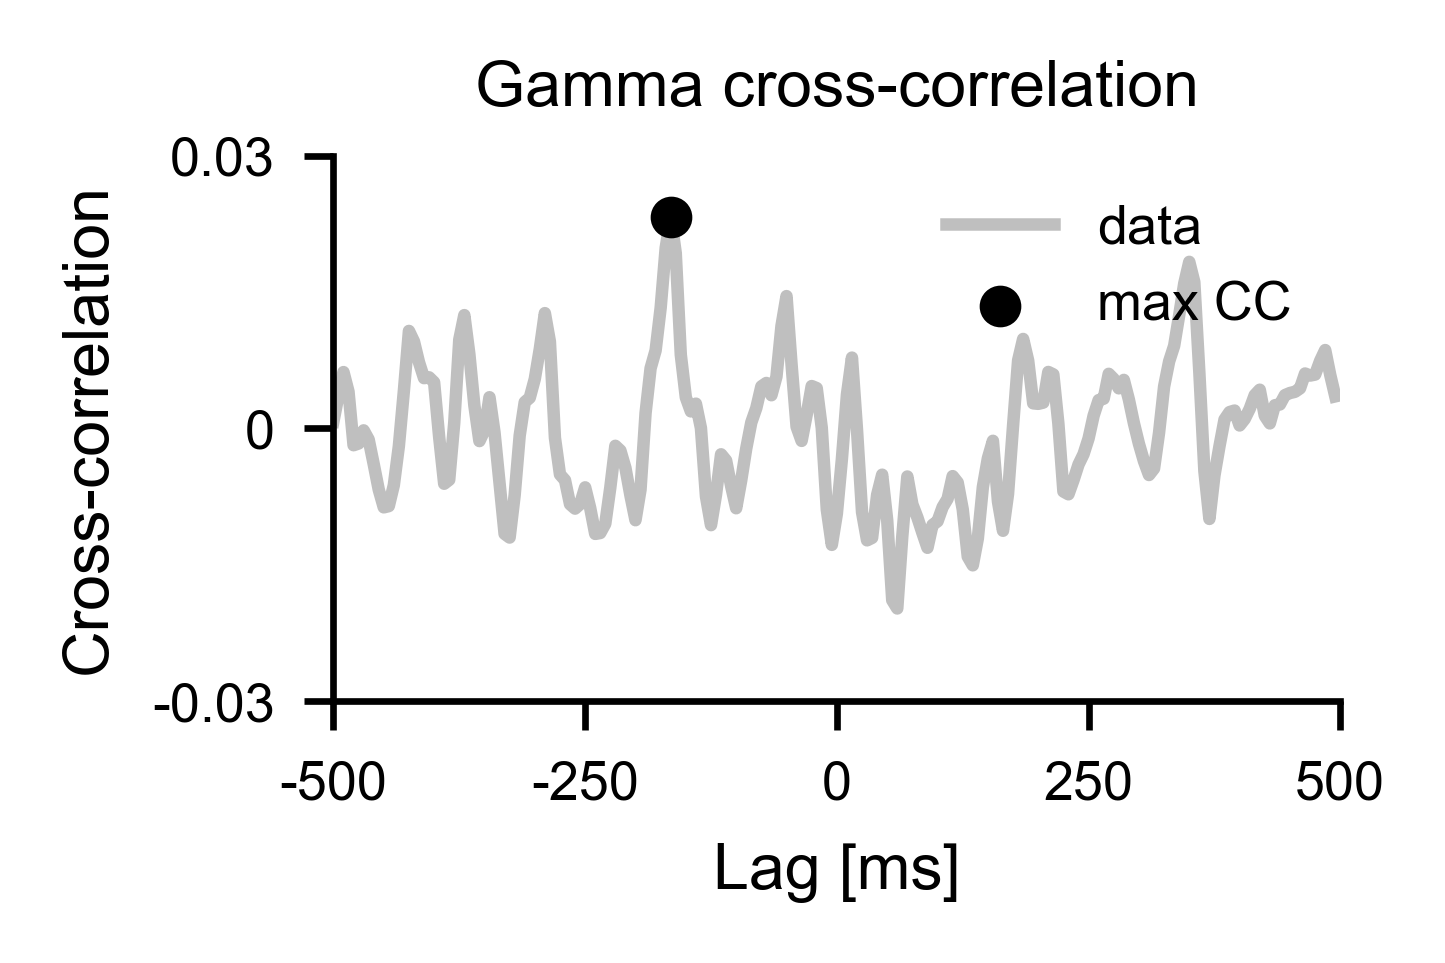

In [52]:
# Figsize in cm
figsize = (5.5, 5.5)

fig, ax = plt.subplots(figsize=_get_figsize_inches((5.5, 3)), dpi=600)

for stage, data_stage in zip(
    ["R"], [data_R]
):  # ["W", "N3", "R"], [data_W, data_N3, data_R]):

    # Data for 2 channels
    data_ch1 = data_stage[df_info.index[df_info["chan"] == chans[0]]]
    data_ch2 = data_stage[df_info.index[df_info["chan"] == chans[1]]]

    raw = uti.create_RawMNE(np.concatenate([data_ch1, data_ch2], axis=0), chans, sfreq)
    epo = uti.create_epo(raw, freq_band=True, band_freqs=[40, 80])

    # Get epoched data
    data_ch1 = epo.get_data(picks=chans[0]).squeeze()
    data_ch2 = epo.get_data(picks=chans[1]).squeeze()

    # Compute cross-correlation
    corr_avg = []
    for k in range(len(data_ch1)):
        ch1_norm = (data_ch1[k] - data_ch1[k].mean()) / np.linalg.norm(data_ch1[k])
        ch2_norm = (data_ch2[k] - data_ch2[k].mean()) / np.linalg.norm(data_ch2[k])
        corr = signal.correlate(ch1_norm, ch2_norm, mode="same")
        lags = signal.correlation_lags(len(ch1_norm), len(ch2_norm), mode="same")
        corr_avg.append(corr)
    corr_avg = np.array(corr_avg).mean(axis=0)
    corr_0 = corr_avg[lags == 0][0]
    corr_max = np.max(np.abs(corr_avg))

    # Plot
    ax.plot(
        lags * 1000 / sfreq,
        corr_avg,
        c="grey",
        label="data",
        lw=1.5,
        alpha=0.5,
    )
    # Max
    ax.scatter(
        lags[np.argmax(np.abs(corr_avg))] * 1000 / sfreq,
        corr_max,
        c="k",
        s=16,
        label="max CC",
        zorder=4,
    )
    # Plot parameters
    ax.set_title(
        "Gamma cross-correlation",
        fontsize=fsize.TITLE_SIZE * _get_fontsize_ratio(figsize),
    )
    ax.set_xlim(-500, 500)
    ax.set_xticks(
        [-500, -250, 0, 250, 500],
        labels=[-500, -250, 0, 250, 500],
        fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
    )
    ax.set_xlabel("Lag [ms]", fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio(figsize))
    ax.set_ylim(-0.03, 0.03)
    ax.set_yticks(
        [-0.03, 0, 0.03],
        labels=[-0.03, 0, 0.03],
        fontsize=fsize.TICK_SIZE * _get_fontsize_ratio(figsize),
    )
    ax.set_ylabel(
        "Cross-correlation", fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio(figsize)
    )
    ax.spines[["top", "right"]].set_visible(False)

ax.legend(frameon=False, fontsize=fsize.TEXT_SIZE * _get_fontsize_ratio(figsize))
fig.savefig(fig_path.joinpath("Fig_0", f"Fig0_CC_{pats[0]}_gamma.svg"), format="svg")
plt.show()

In [32]:
df_sc = pd.read_csv(data_path.joinpath("Results_SC", "SC_W.csv"), index_col=0)

df_sc_gamma = pd.read_csv(
    data_path.joinpath("Results_SC_gamma", "SC_W.csv"), index_col=0
)

In [61]:
df_sc[
    (df_sc["lobe_1"] != df_sc["lobe_2"])
    & (df_sc["corr_max"] >= 0.2)
    & (df_sc_gamma["corr_max"] >= 0.03)
    & (df_sc["dist"] >= 10)
]

,ch_1,ch_2,lobe_1,lobe_2,region_1,region_2,mmp_1,mmp_2,dist,corr_0,corr_max,corrc_max,lag_max,pat
8238,GD034Lr_3,GD034Lu_2,Frontal,Temporal,Central operculum,Planum temporale,FOP3,LBelt,36.810325,-0.214569,0.230878,0.183954,1,34
8239,GD034Lr_3,GD034Lu_3,Frontal,Temporal,Central operculum,Planum temporale,FOP3,PBelt,37.269290,-0.209689,0.216770,0.145002,1,34
9151,GD041Lr_6,GD041Ls_6,Frontal,Parietal,Central operculum,Parietal operculum,OP1,PFcm,11.090537,-0.260337,0.271035,0.227080,-1,41
13648,MM076LOF4,MM076LOF6,Insula,Frontal,Anterior insula,Frontal operculum,AVI,47l,12.083046,0.293796,0.293796,0.093897,0,76
13876,MM078LH7,MM078LCa2,Temporal,Frontal,Middle temporal gyrus,Anterior cingulate,STSva,a32pr,73.472784,-0.106067,0.211139,0.326243,4,78
13878,MM078LH7,MM078LCs2,Temporal,Frontal,Middle temporal gyrus,Supplementary motor cortex,STSva,p32pr,72.097157,0.151654,0.249395,0.099192,-11,78
13887,MM078LH8,MM078LCa2,Temporal,Frontal,Middle temporal gyrus,Anterior cingulate,TE1m,a32pr,77.092477,-0.072049,0.239936,0.315698,5,78
13957,MD079RPC10,MD079RIP4,Parietal,Temporal,Parietal operculum,Planum temporale,PFcm,RI,12.737739,0.251017,0.329925,0.336742,-4,79
13959,MD079RPC10,MD079RIP6,Parietal,Temporal,Parietal operculum,Planum temporale,PFcm,A4,19.704060,0.300810,0.309347,0.128253,-1,79
13983,MD079RPC13,MD079RIP6,Parietal,Temporal,Parietal operculum,Planum temporale,PF,A4,13.000000,-0.047964,0.204748,0.194719,-16,79
